In [1]:
import polars

max_length = 300_000
dataframe = polars.read_csv('../data/chessData.csv')
dataframe = dataframe.sample(shuffle=True, seed=42, n=max_length)
print(dataframe.head())

shape: (5, 2)
┌─────────────────────────────────┬────────────┐
│ FEN                             ┆ Evaluation │
│ ---                             ┆ ---        │
│ str                             ┆ str        │
╞═════════════════════════════════╪════════════╡
│ r1bq2k1/1p3pbp/p2p1np1/2pPr3/P… ┆ +57        │
│ R5k1/2nbqpp1/3b1n1p/2pPp3/2P1P… ┆ +82        │
│ rqr3k1/3npp2/3p2p1/1N1P3p/P1pR… ┆ +116       │
│ 8/5pp1/k5p1/1pK5/8/7P/5PP1/8 w… ┆ -317       │
│ 3r2k1/5p1p/1RN1p3/5nP1/1p6/2b1… ┆ +46        │
└─────────────────────────────────┴────────────┘


In [2]:
import numpy
from typing import Generator, Tuple
import itertools
import chess

ProductPiece = Tuple[chess.PieceType, chess.Color]


def generator_pieces() -> Generator[ProductPiece, None, None]:
    return itertools.product(chess.PIECE_TYPES, chess.COLORS)


def tokenize_fen(fen: str):
    board = chess.Board(fen=fen)
    board_array = numpy.array([], ndmin=2)

    for piece_type, color in generator_pieces():
        # Obtiens les pièces du plateau
        square_set = board.pieces(piece_type, color)

        # Crée un masque (numpy va inverser les axes, donc on utilise mirror)
        mask = square_set.mirror().tolist()

        # Convertit le masque en tableau numpy et en one-hot
        piece_array = numpy.array(mask).astype(int)

        # Ajoute le tableau de pièces au tableau de plateau
        board_array = numpy.append(board_array, piece_array)

    board_array = board_array.astype(numpy.uint8)
    return tuple(board_array)

In [3]:
start_pos = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
result = tokenize_fen(start_pos)
print(len(result))
print(sum(result))

print(sum(result[:64]))  # white pawn
print(sum(result[64:128]))  # black pawn

print(sum(result[-128:-64]))  # white king
print(sum(result[-64:]))  # black king

768
32
8
8
1
1


In [4]:
fen_column = "FEN"
score_column = "Evaluation"

expression = polars.col(fen_column).map_elements(tokenize_fen, return_dtype=polars.List(polars.UInt8))
preprocess_df = dataframe.with_columns(expression)

# Filtrer les lignes où la colonne ne contient pas '#-'
filtered_df = preprocess_df.filter(~polars.col(score_column).str.contains('#-'))
filtered_df = filtered_df.filter(~polars.col(score_column).str.contains('#+'))

# Convertir la colonne en entier
filtered_df = filtered_df.with_columns(polars.col(score_column).cast(polars.Int16))

min_value = filtered_df[score_column].min()
max_value = filtered_df[score_column].max()

print(f"Min value : '{min_value:.2f}  -  Max value : {max_value:.2f}")

# Le dataset contient '#+0' ou '#-0' dans score quand il y'a un mat, on remplace par le maximum de la couleur
expression = (
    polars
    .when(polars.col(score_column).str.contains('#+'))
    .then(polars.lit(f'{max_value}'))

    .when(polars.col(score_column).str.contains('#-'))
    .then(polars.lit(f'{min_value}'))

    .otherwise(polars.col(score_column))
    .alias(score_column))

preprocess_df = preprocess_df.with_columns(expression)

# Convertit le dtype string de 'score' en dtype float
expression = polars.col(score_column).cast(polars.Int16)
preprocess_df = preprocess_df.with_columns(expression)

# Ré-équilibre le dataset 
expression = polars.col(score_column).ne(0)
preprocess_df = preprocess_df.filter(expression)

# Si une valeur dépasse 2000 ou -2000, le remplace par 2000 ou -2000
# expression = polars.col(score_column).clip(-2000, 2000)
# preprocess_df = preprocess_df.with_columns(expression)

conditions = (
    polars.when(polars.col(score_column) >= 0).then(1)
    .when((polars.col(score_column) < 0)).then(0)
)
# Ajouter la colonne de classification au DataFrame
preprocess_df = preprocess_df.with_columns(conditions.alias("classification"))

# Renomme les colonnes en 'fen' et 'score'
preprocess_df = preprocess_df.rename({fen_column: 'fen', score_column: 'score'})

Min value : '-8109.00  -  Max value : 14792.00


In [5]:
print(preprocess_df.head())

shape: (5, 3)
┌─────────────┬───────┬────────────────┐
│ fen         ┆ score ┆ classification │
│ ---         ┆ ---   ┆ ---            │
│ list[u8]    ┆ i16   ┆ i32            │
╞═════════════╪═══════╪════════════════╡
│ [0, 0, … 0] ┆ 57    ┆ 1              │
│ [0, 0, … 0] ┆ 82    ┆ 1              │
│ [0, 0, … 0] ┆ 116   ┆ 1              │
│ [0, 0, … 0] ┆ -317  ┆ 0              │
│ [0, 0, … 0] ┆ 46    ┆ 1              │
└─────────────┴───────┴────────────────┘


In [6]:
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset


class ChessDataset(Dataset):
    def __init__(self, preprocess_df: polars.DataFrame):
        self.dataframe = preprocess_df

    def __getitem__(self, index: int):
        # Récupère la FEN et le score
        array = self.dataframe['fen'][index]
        _classification = self.dataframe['classification'][index]
        classification = [0 for i in range(2)]
        classification[_classification] = 1

        # Convertit le tableau numpy en tenseur PyTorch
        tensor_array = torch.tensor(array, dtype=torch.float32)
        tensor_classification = torch.tensor(classification, dtype=torch.float32)

        return tensor_array, tensor_classification

    def __len__(self):
        return len(self.dataframe)

    def hist_score(self, bins: int = 51):
        """
        Affiche un histogramme de la colonne 'score'.

        Notes:
            Incrémente bins de 1 si celui-ci est pair, cela permet d'afficher le nombre de
            zeros dans la colonne 'score'. En impair, nous n'avons que pour > 0 ou < 0.

        Args:
            bins (int): Nombre de "bacs" pour l'histogramme. Defaults to 51.

        Returns:
            None
        """
        # Si le nombre de bacs est pair, on l'incrémente de 1
        bins = bins + 1 if bins % 2 == 0 else bins

        # Créer un histogramme de la colonne 'score'
        plt.hist(self.dataframe['classification'], bins=bins)

        # Ajouter des étiquettes et un titre
        plt.xlabel('Valeur')
        plt.ylabel('Fréquence')
        plt.title('Distribution de la colonne "score"')

        # Afficher le graphique
        plt.show()

In [14]:
from torch import nn


import torch
import torch.nn as nn
import torch.optim as optim

class ChessModel(nn.Module):
    def __init__(self, input_size: int = 768):
        super(ChessModel, self).__init__()
        self.linear_1 = nn.Linear(input_size, 2048)
        self.linear_2 = nn.Linear(2048, 1024)
        self.linear_3 = nn.Linear(1024, 512)
        self.linear_4 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _x = self.relu(self.linear_1(x))
        _x = self.dropout(_x)
        _x = self.relu(self.linear_2(_x))
        _x = self.dropout(_x)
        _x = self.relu(self.linear_3(_x))
        _x = self.dropout(_x)
        _x = self.softmax(self.linear_4(_x))
        return _x

    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

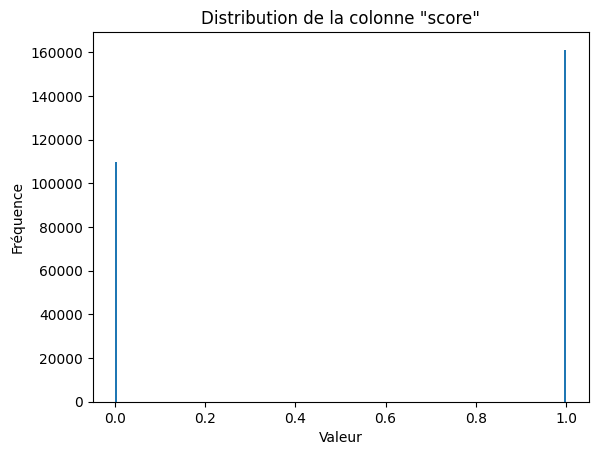

shape: (2, 2)
┌────────────────┬────────┐
│ classification ┆ count  │
│ ---            ┆ ---    │
│ i32            ┆ u32    │
╞════════════════╪════════╡
│ 0              ┆ 109613 │
│ 1              ┆ 161163 │
└────────────────┴────────┘


In [15]:
model = ChessModel()
dataset = ChessDataset(preprocess_df=preprocess_df)
dataset.hist_score(bins=201)
print(preprocess_df.get_column('classification').value_counts().sort("count"))

In [16]:
import logging
import statistics
from typing import Literal, Type

import torch
from torch import nn
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler, LinearLR
from torch.utils.data import DataLoader
from torchmetrics import Metric, MeanAbsoluteError
from tqdm import tqdm

from src import MODEL_PATH


def train_model(
        model: nn.Module,

        train_loader: DataLoader,
        tests_loader: DataLoader,
        validation_loader: DataLoader,

        num_epochs: int = 20,
        device: Literal['cuda', 'cuda'] = 'cuda',

        optimizer: Type[Optimizer] = torch.optim.Adam,
        metric: Metric = MeanAbsoluteError,
        criterion: _Loss = nn.MSELoss,

        lr: float = 1e-4,

        scheduler: Type[LRScheduler] = LinearLR,
        start_factor: float = 1.0,
        end_factor: float = 1e-6,
        total_iters: int = 10
):
    train_score, tests_score, validation_score = 0, 0, 0

    # Crée le modèle
    model = model.to('cuda')
    logging.info(f"Device: {model.device}")

    # noinspection PyArgumentList
    optimizer = optimizer(model.parameters(), lr=lr)

    # noinspection PyArgumentList
    scheduler = scheduler(
        optimizer=optimizer,
        start_factor=start_factor,
        end_factor=end_factor,
        total_iters=total_iters
    )

    metric_name = metric.__class__.__name__

    # Entraîne le modèle
    for epoch in range(num_epochs):
        pbar = tqdm(train_loader, total=len(train_loader), leave=False)

        list_loss = []
        for x, y in pbar:
            x = x.to(device='cuda')
            y = y.to(device='cuda')  # Met 'y' en batch_size de 1

            predictions = model(x).to(device='cuda')

            loss = criterion(predictions, y).to(device='cuda')
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            pbar.set_description(f"Epochs: {epoch + 1}/{num_epochs}  -  Loss: {loss.item():.1e}")
            list_loss.append(loss.item())

        scheduler.step()
        # afficher sous forme 1e-3, 2e-3, 3e-3, etc.
        tqdm.write(f"Learning rate: {scheduler.get_last_lr()[0]:.1e}")
        train_score = check_accuracy(train_loader, model, metric)
        tests_score = check_accuracy(tests_loader, model, metric)

        avg_loss = statistics.mean(list_loss)
        tqdm.write(f"Epochs: {epoch + 1}/{num_epochs}  -  Loss: {avg_loss:.1e}  -  Train ({metric_name}): {train_score:.2f}  -  Tests ({metric_name}) : {tests_score:.2f}")

        # Sauvegarde le modèle
        path = MODEL_PATH / f"model_{epoch + 1}.pth"
        torch.save(model.state_dict(), path)

    # Affiche les derniers scores sur tout le dataset (tout les batchs)
    validation_score = check_accuracy(validation_loader, model, metric)

    logging.info(f"[Score global train] : {train_score:.2f}%")
    logging.info(f"[Score global tests] : {tests_score:.2f}%")
    logging.info(f"[Score global validation] : {validation_score:.2f}%")


def check_accuracy(
        loader: DataLoader,
        model: nn.Module,
        metrics: Metric,
):
    """
    Fonction pour calculer la précision du modèle
    """
    list_accuracy = []

    # Récupère le device du modèle
    device = model.device

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)  # Met 'y' en batch_size de 1

            predictions = model(x).to(device=device)

            accuracy = metrics(preds=predictions, target=y)
            list_accuracy.append(accuracy.item())

    global_accuracy = statistics.mean(list_accuracy)
    return global_accuracy


In [17]:
import os

import torchmetrics
from typing import Literal
from src.dataset import split_dataset

# Autres paramètres
device: Literal['cuda', 'cuda'] = 'cuda'

# Paramètres du dataset
batch_size: int = 256
random_seed: int = 42
ratio_tests: float = 0.2
ratio_validation: float = 0.2

# Paramètres du modèle (apprentissage)
num_epochs: int = 100
lr: float = 1e-3

# Paramètres du scheduler_lr (apprentissage)
start_factor: float = 1.0
end_factor: float = 0.01
total_iters: int = 20

metric = torchmetrics.Accuracy(task="binary", num_classes=2, top_k=2).to(device)
criterion = nn.CrossEntropyLoss()

list_loaders = split_dataset(
    dataset=dataset,
    batch_size=batch_size,
    shuffle_dataset=False,
    random_seed=random_seed,
    ratio_tests=ratio_tests,
    ratio_validation=ratio_validation
)

train_loader, tests_loader, validation_loader = list_loaders
import gc

gc.collect()

torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
model = model.to(device)


train_model(
    device=device,

    model=model,
    train_loader=train_loader,
    tests_loader=tests_loader,
    validation_loader=validation_loader,

    num_epochs=num_epochs,
    lr=lr,

    start_factor=start_factor,
    end_factor=end_factor,
    total_iters=total_iters,

    metric=metric,
    criterion=criterion,
)

Learning rate: 9.5e-04
Epochs: 1/100  -  Loss: 6.1e-01  -  Train (BinaryAccuracy): 0.72  -  Tests (BinaryAccuracy) : 0.70


Learning rate: 9.0e-04
Epochs: 2/100  -  Loss: 5.7e-01  -  Train (BinaryAccuracy): 0.75  -  Tests (BinaryAccuracy) : 0.71


Learning rate: 8.5e-04
Epochs: 3/100  -  Loss: 5.5e-01  -  Train (BinaryAccuracy): 0.77  -  Tests (BinaryAccuracy) : 0.72


Learning rate: 8.0e-04
Epochs: 4/100  -  Loss: 5.3e-01  -  Train (BinaryAccuracy): 0.79  -  Tests (BinaryAccuracy) : 0.72


Learning rate: 7.5e-04
Epochs: 5/100  -  Loss: 5.2e-01  -  Train (BinaryAccuracy): 0.80  -  Tests (BinaryAccuracy) : 0.72


Learning rate: 7.0e-04
Epochs: 6/100  -  Loss: 5.0e-01  -  Train (BinaryAccuracy): 0.82  -  Tests (BinaryAccuracy) : 0.72


Learning rate: 6.5e-04
Epochs: 7/100  -  Loss: 4.9e-01  -  Train (BinaryAccuracy): 0.83  -  Tests (BinaryAccuracy) : 0.72


Learning rate: 6.0e-04
Epochs: 8/100  -  Loss: 4.8e-01  -  Train (BinaryAccuracy): 0.84  -  Tests (BinaryAccuracy) : 0.72


Learning rate: 5.5e-04
Epochs: 9/100  -  Loss: 4.7e-01  -  Train (BinaryAccuracy): 0.85  -  Tests (BinaryAccuracy) : 0.72


Learning rate: 5.1e-04
Epochs: 10/100  -  Loss: 4.6e-01  -  Train (BinaryAccuracy): 0.86  -  Tests (BinaryAccuracy) : 0.72


Learning rate: 4.6e-04
Epochs: 11/100  -  Loss: 4.5e-01  -  Train (BinaryAccuracy): 0.87  -  Tests (BinaryAccuracy) : 0.72


Learning rate: 4.1e-04
Epochs: 12/100  -  Loss: 4.4e-01  -  Train (BinaryAccuracy): 0.87  -  Tests (BinaryAccuracy) : 0.72


Learning rate: 3.6e-04


KeyboardInterrupt: 

In [18]:
from src import MODEL_PATH

path = MODEL_PATH / 'model_12.pth'
dict_model = torch.load(path, map_location='cuda')
model = ChessModel().to(device)
model.load_state_dict(dict_model)


def analys_model(fen: str):
    fen_array = tokenize_fen(fen)
    fen_tensor = torch.tensor(fen_array, dtype=torch.float32).view(1, -1).to(device)
    prediction = model(fen_tensor).argmax().item()

    print(f"Prédiction du modèle: {prediction:.2f}")
    print()


list_fen = [
    "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1",  # Position de base
    "r1bqkb1r/pppp1ppp/2n2n2/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 4 4",  # Mat berger, Mat en 1 pour blanc
    "4k3/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQ - 0 1",  # Noir n'ont qu'un roi
    "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/4K3 w kq - 0 1",  # Blanc n'ont qu'un roi
    "r3rbk1/p4ppp/8/2Nqp3/1p1P2b1/1P3N2/P2P1PPP/2RQR1K1 w - - 1 21"  # Position égale éloignée GMI (reputé légèrement favorable noir)
]

for fen in list_fen:
    analys_model(fen)

Prédiction du modèle: 0.00

Prédiction du modèle: 0.00

Prédiction du modèle: 1.00

Prédiction du modèle: 0.00

Prédiction du modèle: 1.00

